# Keypoint Detection using Mask R-CNN

In this notebook, we will introduce keypoint detection.  Keypoints are meaningful points of an object detected in an image.  For example, facial or body keypoint detection can be used for emotion and pose recognition.   We will demostrate how to do human body keypoints detection using the pretrained Keypoint R-CNN model in PyTorch.  The Keypoint R-CNN is described in [Mask R-CNN](https://arxiv.org/abs/1703.06870) as well.

## Initialization

In [1]:
# ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [18]:
# imports
from PIL import Image
import scrapbook as sb
import urllib.request

# torch
import torch

# utility
import sys
sys.path.append("../../")

from utils_cv.common.data import data_path, unzip_url
from utils_cv.common.gpu import which_processor
from utils_cv.detection.data import Urls, coco_labels
from utils_cv.detection.dataset import DetectionDataset
from utils_cv.detection.keypoint import CanKeypoints, CartonKeypoints, COCOPersonKeypoints, MilkBottleKeypoints
from utils_cv.detection.model import DetectionLearner, get_pretrained_keypointrcnn
from utils_cv.detection.plot import plot_detections, PlotSettings

# variables
device = torch.device('cuda')

which_processor()

Torch is using GPU: Quadro P400


In [3]:
DATA_PATH = unzip_url(Urls.fridge_objects_keypoint_path, exist_ok=True)
EPOCHS = 10
THRESHOLD = 0.55
DEVICE = torch.device("cpu")
PLOT_SETTINGS = PlotSettings(
    text_color=(0, 0, 0),
    keypoint_color=(0, 255, 0),
)

## Prediction with Pre-trained Model

### Preparation

We will use an image from the Internet.

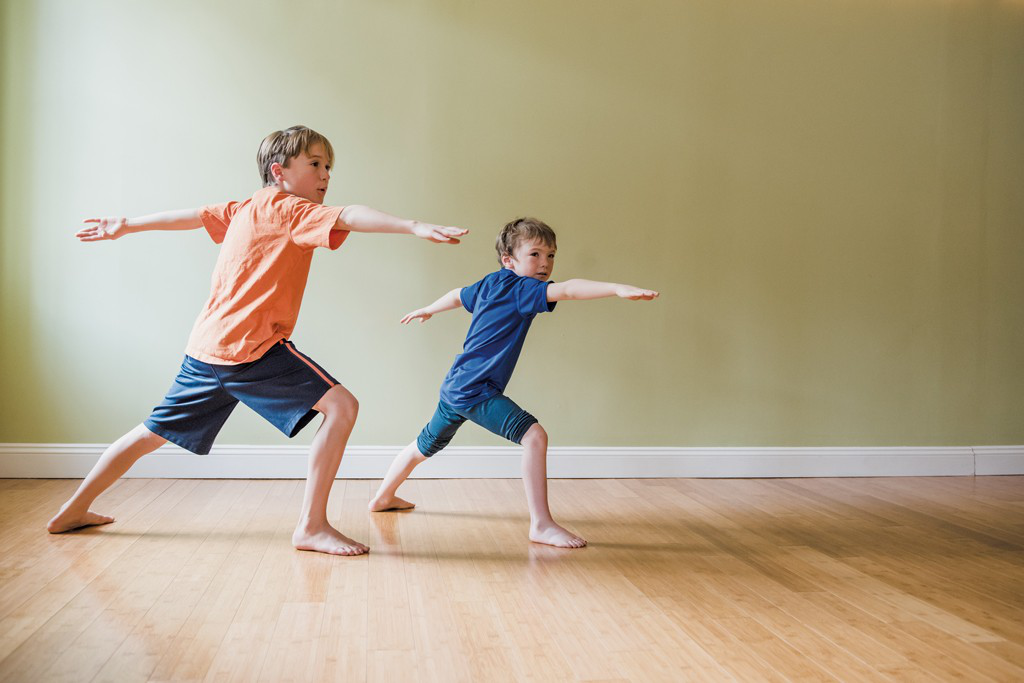

In [4]:
# download image
img_url = "https://media1.fdncms.com/kidsvt/imager/u/original/4282458/yogaposeofthemonth1-1-28d965b85e30c074.jpg"
img_path = data_path() / img_url.split('/')[-1]
urllib.request.urlretrieve(img_url, img_path)

# show image
Image.open(img_path)

Similar to [01_training_introduction notebook](https://render.githubusercontent.com/view/01_training_introduction.ipynb), we can use `get_pretrained_keypointrcnn()` to get the pretrained Keypoint R-CNN model in PyTorch to create a `DetectionLearner`.

In [5]:
# get pretrained keypoint rcnn model
person_detector = DetectionLearner(
    model=get_pretrained_keypointrcnn(),
    labels=coco_labels()[1:],
    device=DEVICE,
)

The pretrained model is built on the [COCO train2017 dataset (118K/18GB)](http://images.cocodataset.org/zips/train2017.zip) with 17 annotated human body keypoints.

In [6]:
[(index, label) for index, label in enumerate(COCOPersonKeypoints.meta["labels"])]

[(0, 'nose'),
 (1, 'left_eye'),
 (2, 'right_eye'),
 (3, 'left_ear'),
 (4, 'right_ear'),
 (5, 'left_shoulder'),
 (6, 'right_shoulder'),
 (7, 'left_elbow'),
 (8, 'right_elbow'),
 (9, 'left_wrist'),
 (10, 'right_wrist'),
 (11, 'left_hip'),
 (12, 'right_hip'),
 (13, 'left_knee'),
 (14, 'right_knee'),
 (15, 'left_ankle'),
 (16, 'right_ankle')]

Keypoints of an object can be connected by edges in some order for visualization.

In [7]:
COCOPersonKeypoints.meta["skeleton"]

[[15, 13],
 [13, 11],
 [16, 14],
 [14, 12],
 [11, 12],
 [5, 11],
 [6, 12],
 [5, 6],
 [5, 7],
 [6, 8],
 [7, 9],
 [8, 10],
 [1, 2],
 [0, 1],
 [0, 2],
 [1, 3],
 [2, 4],
 [3, 5],
 [4, 6]]

### Prediction

The results from `DetectionLearner.predict()` is a `Dict` contains `det_bboxes` and `keypoints`.

In [8]:
# predict
pred = person_detector.predict(img_path, threshold=THRESHOLD)
pred["det_bboxes"]

[{Bbox object: [left=42, top=134, right=443, bottom=554] | <person> | label:1 | path:/home/simon/Copy/Projects/work/vb/cvbp/repo/fork-cvbp/data/yogaposeofthemonth1-1-28d965b85e30c074.jpg} | score: 0.9999191761016846,
 {Bbox object: [left=368, top=217, right=649, bottom=552] | <person> | label:1 | path:/home/simon/Copy/Projects/work/vb/cvbp/repo/fork-cvbp/data/yogaposeofthemonth1-1-28d965b85e30c074.jpg} | score: 0.9999122619628906]

A keypoint is represented by its coordinate and visibility in the image.  `0` means invisible and `1` visible.

In [9]:
pred["keypoints"]

array([[[323.26953, 173.23004,   1.     ],
        [322.41705, 163.84773,   1.     ],
        [313.89215, 162.9948 ,   1.     ],
        [278.08768, 170.67123,   1.     ],
        [279.7927 , 170.67123,   1.     ],
        [242.2832 , 207.34749,   1.     ],
        [294.28497, 209.90633,   1.     ],
        [192.83893, 215.87686,   1.     ],
        [349.6967 , 216.72981,   1.     ],
        [128.04987, 224.40623,   1.     ],
        [408.51828, 225.25919,   1.     ],
        [208.1837 , 348.93497,   1.     ],
        [257.62796, 352.3467 ,   1.     ],
        [151.91951, 434.22864,   1.     ],
        [343.72925, 411.19937,   1.     ],
        [ 72.63817, 509.28705,   1.     ],
        [311.33472, 526.34576,   1.     ]],

       [[544.94995, 263.02124,   1.     ],
        [550.06683, 253.64337,   1.     ],
        [534.7163 , 253.64337,   1.     ],
        [504.86823, 259.6111 ,   1.     ],
        [508.27945, 259.6111 ,   1.     ],
        [488.66498, 281.777  ,   1.     ],
        [

### Visualization

Likewise, we can use `plot_detections()` to visulize the predicted bounding boxes and keypoints.

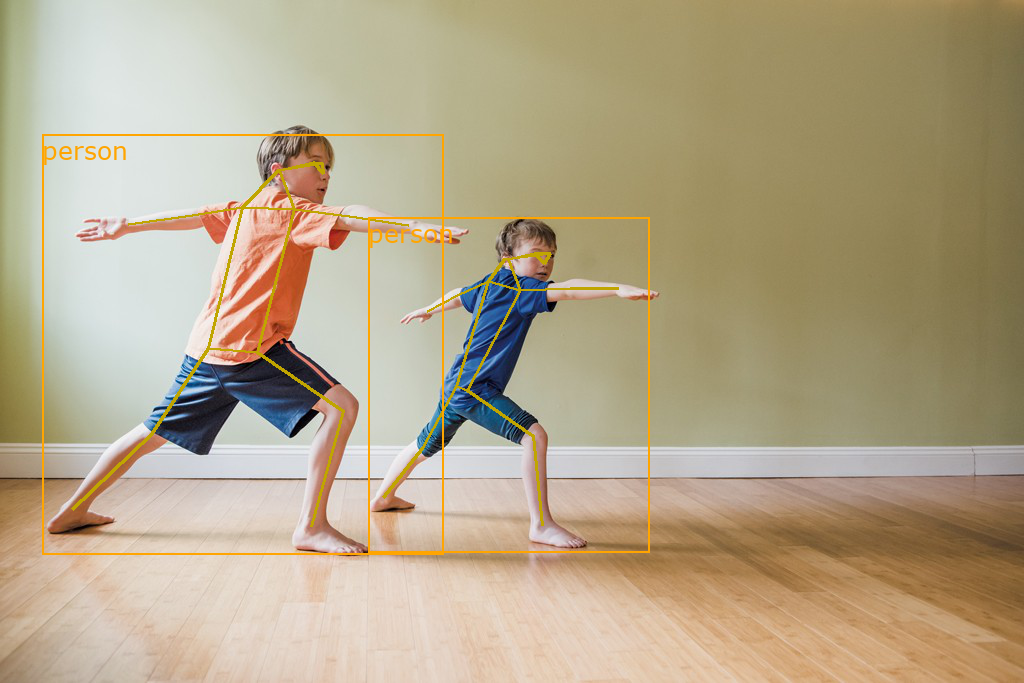

In [10]:
# plot
plot_detections(pred, keypoint_meta=COCOPersonKeypoints.to_dict())

## Tuning with Custom Dataset


### Browse and Prepare the Dataset

We are going to use the odFridgeObjectsKeypoint datasets for illustration. The dataset has already downloaded and unzipped into `DATA_PATH`. This dataset includes 30 images of 4 class labels: `can`, `carton`, `milk_bottle` and `water_bottle`.

```
odFridgeObjectsKeypoints/
├── annotations
│   ├── 1.xml
│   ├── 2.xml
│   ├── ...
│   ├── 29.xml
│   └── 30.xml
└── images
    ├── 1.jpg
    ├── 2.jpg
    ├── ...
    ├── 29.jpg
    └── 30.jpg
```

The `images` directory contains original images. The annotations in the `annotations` directory are of format [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/) shown as in [01_training_introduction notebook](01_training_introduction.ipynb).  The difference in the annotations from [01_training_introduction notebook](01_training_introduction.ipynb) is the additional information on keypoints.

```xml
<annotation>
        <folder>images</folder>
        <filename>100.jpg</filename>
        <path>../images/100.jpg</path>
        <source>
                <database>Unknown</database>
        </source>
        <size>
                <width>499</width>
                <height>666</height>
                <depth>3</depth>
        </size>
        <segmented>0</segmented>
        <object>
                <name>can</name>
                <pose>Unspecified</pose>
                <truncated>0</truncated>
                <difficult>0</difficult>
                <bndbox>
                        <xmin>130</xmin>
                        <ymin>271</ymin>
                        <xmax>367</xmax>
                        <ymax>467</ymax>
                </bndbox>
                <keypoints>
                        <left_collar>
                                <x>142</x>
                                <y>349</y>
                        </left_collar>
                        <right_collar>
                                <x>186</x>
                                <y>278</y>
                        </right_collar>
                        <left_shoulder>
                                <x>152</x>
                                <y>371</y>
                        </left_shoulder>
                        <right_shoulder>
                                <x>206</x>
                                <y>277</y>
                        </right_shoulder>
                        <left_bottom>
                                <x>276</x>
                                <y>455</y>
                        </left_bottom>
                        <right_bottom>
                                <x>343</x>
                                <y>339</y>
                        </right_bottom>
                </keypoints>
        </object>
</annotation>
```

To load the data, we need to create a Dataset object class that Torchvision knows how to use.  To make it more convinient, we've created a `DetectionDataset`class that knows how to extract annotation information from the Pascal VOC format and meet the requirements of the Torchvision dataset object class.  There is an additional parameter `keypoint_meta` for specifying the meta data for the keypoints we are going to predict.  The keypoints meta data should be a dict that contains `category`, `labels`, `skeleton` and `hflip_inds`.  `category` is the category of the objects we are going to do keypoint detetion, `labels` is the names of the keypoints, `skeleton` defines the relationship among the keypoints, and `hflip_inds` indicates the order of keypoints when the image being flipped.  We defined `MilkBottleKeypoints`, `CartonKeypoints`, `CanKeypoints` and `WaterBottleKeypoints` for the 4 categories in the odFridgeObjectsKeypoint dataset.  Their `.to_dict()` method can be used to generate the meta data.

83


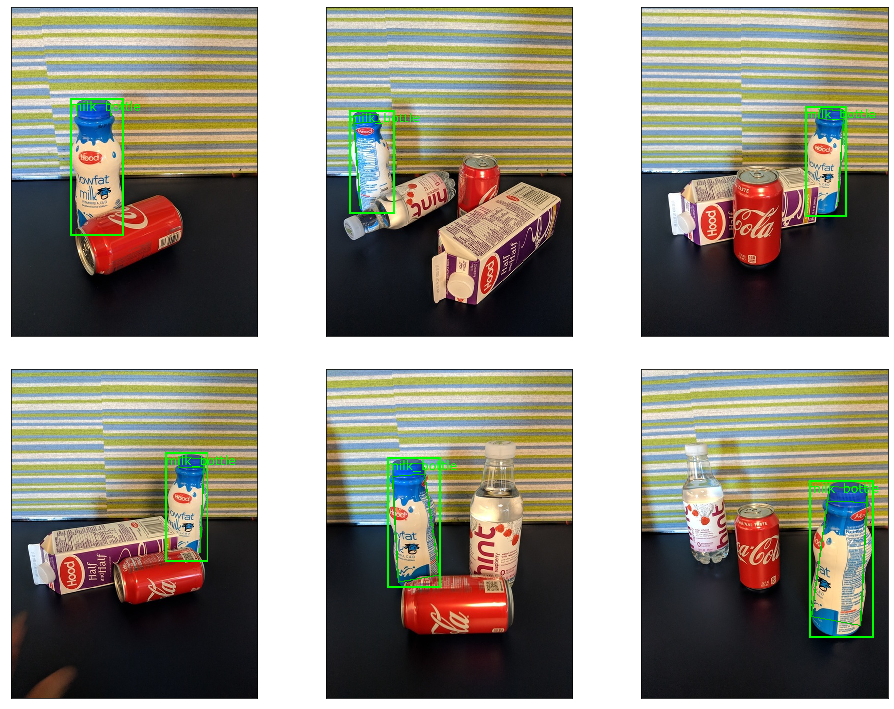

In [19]:
milkbottles = DetectionDataset(
    root=DATA_PATH, 
    keypoint_meta = MilkBottleKeypoints.to_dict()
)
print(len(cans))
milkbottles.show_ims(rows=2, seed=168)

Now `DetectionDataset` collected all images containing `can`s inside.

### Re-train

To tune the model, we need to specify the number of keypoints in `get_pretrained_keypointrcnn()` and pass the dataset to `DetectionLearner` before calling its `.fit()` method.

In [20]:
# train
milkbottle_model = get_pretrained_keypointrcnn(
    num_classes=2,  # __background__ and milk_bottle
    num_keypoints=len(MilkBottleKeypoints.meta["labels"]),
)
milkbottle_detector = DetectionLearner(dataset=milkbottles, model=milkbottle_model, device=DEVICE)
milkbottle_detector.fit(epochs=EPOCHS, lr=0.005, print_freq=30, skip_evaluation=True)

Epoch: [0]  [ 0/22]  eta: 0:06:11  lr: 0.000243  loss: 8.9705 (8.9705)  loss_classifier: 0.7303 (0.7303)  loss_box_reg: 0.1120 (0.1120)  loss_keypoint: 8.1111 (8.1111)  loss_objectness: 0.0074 (0.0074)  loss_rpn_box_reg: 0.0096 (0.0096)  time: 16.8821  data: 2.3233  max mem: 0
Epoch: [0]  [21/22]  eta: 0:00:12  lr: 0.005000  loss: 7.7648 (7.4406)  loss_classifier: 0.0904 (0.2793)  loss_box_reg: 0.0876 (0.0893)  loss_keypoint: 7.5949 (7.0630)  loss_objectness: 0.0033 (0.0048)  loss_rpn_box_reg: 0.0037 (0.0042)  time: 12.4645  data: 0.0046  max mem: 0
Epoch: [0] Total time: 0:04:40 (12.7362 s / it)
Epoch: [1]  [ 0/22]  eta: 0:06:02  lr: 0.005000  loss: 8.7507 (8.7507)  loss_classifier: 0.1064 (0.1064)  loss_box_reg: 0.0775 (0.0775)  loss_keypoint: 8.5534 (8.5534)  loss_objectness: 0.0066 (0.0066)  loss_rpn_box_reg: 0.0068 (0.0068)  time: 16.4868  data: 2.9105  max mem: 0
Epoch: [1]  [21/22]  eta: 0:00:13  lr: 0.005000  loss: 3.0783 (3.6442)  loss_classifier: 0.0694 (0.0773)  loss_box_reg

### Prediction

Now we will do keypint detection on the first milk bottle image.

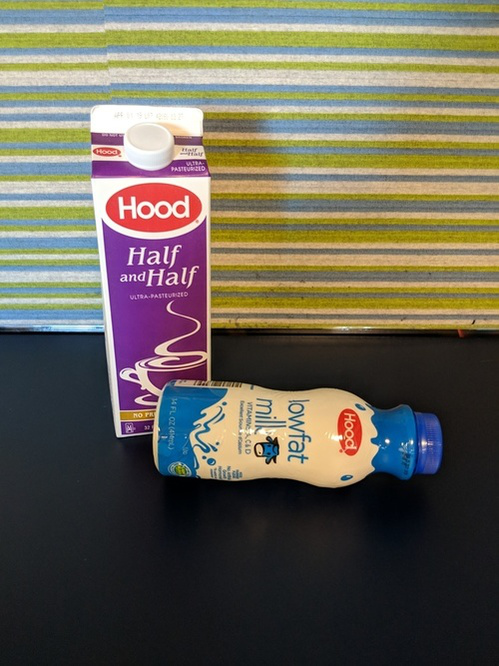

In [21]:
milkbottle_path = milkbottles.im_paths[0]
Image.open(milkbottle_path)

In [25]:
pred = milkbottle_detector.predict(milkbottle_path, threshold=0.9)
pred["det_bboxes"]

[{Bbox object: [left=145, top=386, right=437, bottom=494] | <milk_bottle> | label:1 | path:/home/simon/Copy/Projects/work/vb/cvbp/repo/fork-cvbp/data/odFridgeObjectsKeypoint/images/10.jpg} | score: 0.9624947905540466]

In [26]:
pred["keypoints"]

array([[[159.26192, 469.6996 ,   1.     ],
        [425.58026, 473.4233 ,   1.     ],
        [409.98785, 409.49863,   1.     ],
        [421.2144 , 471.56143,   1.     ],
        [401.8798 , 411.3605 ,   1.     ],
        [161.13301, 472.18207,   1.     ]]], dtype=float32)

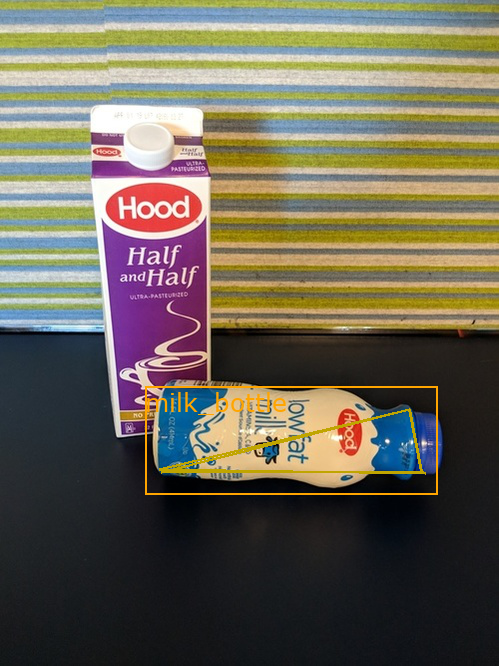

In [27]:
plot_detections(pred, keypoint_meta=MilkBottleKeypoints.to_dict())

### Tune to Detect Keypoints from Another Category

To detect keypoints on objects from other categories, we need to go through the same process as above by preparing the dataset of that category, retaining the model with the dataset with annotated keypoints.

86


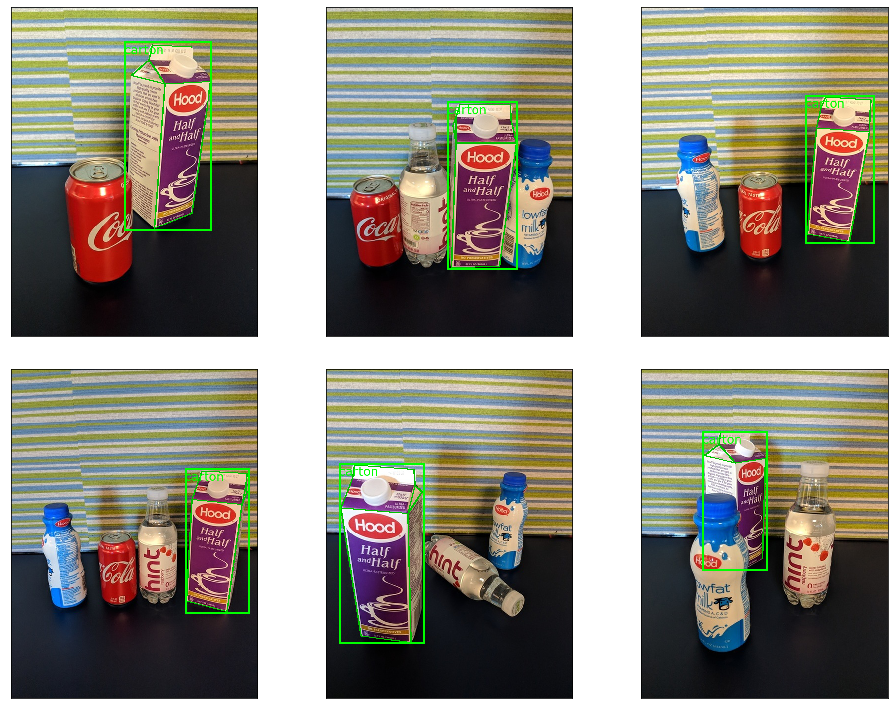

In [28]:
cartons = DetectionDataset(
    root=DATA_PATH, 
    keypoint_meta = CartonKeypoints.to_dict()
)
print(len(cartons))
cartons.show_ims(rows=2, seed=168)

In [29]:
# train
carton_model = get_pretrained_keypointrcnn(
    num_classes=2,  # __background__ and carton
    num_keypoints=len(CartonKeypoints.meta["labels"]),
)
carton_detector = DetectionLearner(dataset=cartons, model=carton_model, device=DEVICE)
carton_detector.fit(epochs=EPOCHS, lr=0.005, print_freq=30, skip_evaluation=True)

Epoch: [0]  [ 0/22]  eta: 0:06:50  lr: 0.000243  loss: 8.7928 (8.7928)  loss_classifier: 0.6451 (0.6451)  loss_box_reg: 0.0949 (0.0949)  loss_keypoint: 8.0280 (8.0280)  loss_objectness: 0.0173 (0.0173)  loss_rpn_box_reg: 0.0075 (0.0075)  time: 18.6425  data: 4.0061  max mem: 0
Epoch: [0]  [21/22]  eta: 0:00:13  lr: 0.005000  loss: 8.2365 (8.3093)  loss_classifier: 0.1201 (0.2656)  loss_box_reg: 0.0745 (0.0736)  loss_keypoint: 7.9921 (7.9451)  loss_objectness: 0.0085 (0.0152)  loss_rpn_box_reg: 0.0098 (0.0098)  time: 13.0846  data: 0.0075  max mem: 0
Epoch: [0] Total time: 0:04:55 (13.4432 s / it)
Epoch: [1]  [ 0/22]  eta: 0:06:56  lr: 0.005000  loss: 8.1139 (8.1139)  loss_classifier: 0.0803 (0.0803)  loss_box_reg: 0.0891 (0.0891)  loss_keypoint: 7.9360 (7.9360)  loss_objectness: 0.0018 (0.0018)  loss_rpn_box_reg: 0.0066 (0.0066)  time: 18.9186  data: 4.5402  max mem: 0
Epoch: [1]  [21/22]  eta: 0:00:14  lr: 0.005000  loss: 5.8956 (6.1641)  loss_classifier: 0.0700 (0.0697)  loss_box_reg

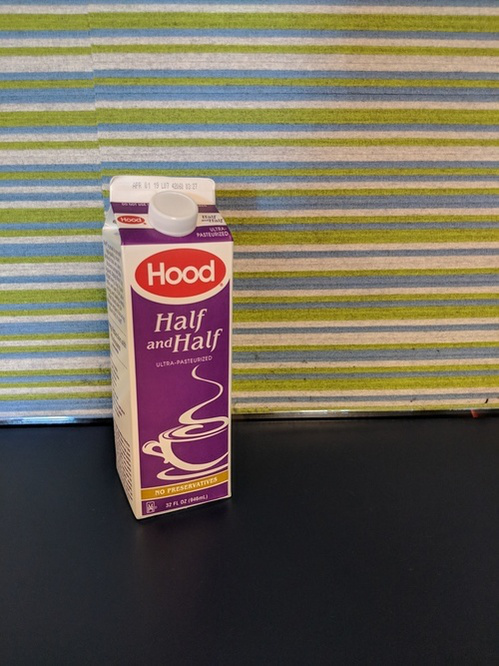

In [30]:
carton_path = cartons.im_paths[0]
Image.open(carton_path)

In [31]:
pred = carton_detector.predict(carton_path, threshold=0.5)
pred["det_bboxes"]

[{Bbox object: [left=100, top=175, right=240, bottom=513] | <carton> | label:1 | path:/home/simon/Copy/Projects/work/vb/cvbp/repo/fork-cvbp/data/odFridgeObjectsKeypoint/images/1.jpg} | score: 0.9989725351333618]

In [32]:
pred["keypoints"]

array([[[175.19547, 204.88351,   1.     ],
        [114.06896, 176.19601,   1.     ],
        [210.1249 , 176.19601,   1.     ],
        [110.95026, 204.88351,   1.     ],
        [215.11482, 204.88351,   1.     ],
        [120.9301 , 247.29114,   1.     ],
        [232.57951, 241.05473,   1.     ],
        [100.34668, 228.5819 ,   1.     ],
        [232.57951, 235.44194,   1.     ],
        [137.14732, 512.3388 ,   1.     ],
        [230.08455, 496.1241 ,   1.     ],
        [117.8114 , 469.93115,   1.     ],
        [231.33205, 494.87683,   1.     ]]], dtype=float32)

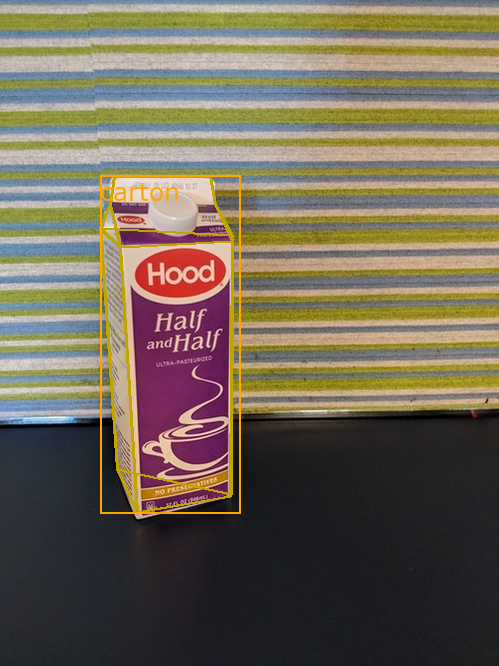

In [33]:
plot_detections(pred, keypoint_meta=CartonKeypoints.to_dict())

Since there are only 30 images in the dataset, the result above is not very good.

## Conclusion

In this notebook, we used the pretrained Keypoint R-CNN model extended from Mask R-CNN to detect keypoints, and demostrated how to tune the model for keypoint detection on custom dataset.